In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import regex as re
import scipy.stats as stats
import matplotlib.pyplot as plt

<a id="section_toc"></a> 
## Tabla de Contenidos

[Carga de Dataset](#section_load_dataset)

$\hspace{.5cm}$[Duplicados](#section_duplicated)

$\hspace{.5cm}$[Columnas desestimadas](#section_irrelevant_columns)

[Columnas de precios](#section_price_columns)

$\hspace{.5cm}$[Obtención de única columna de precios](#section_unique_price_columns)

$\hspace{.5cm}$[Imputación de precios](#section_impute_price_columns)

$\hspace{.5cm}$[Outliers de precios](#section_outliers_price_columns)

[Columna property_type](#section_property_type_column)

[Columna rooms](#section_room_column)

$\hspace{.5cm}$[Imputación de rooms](#section_impute_rooms_columns)

[Columnas m2 y precio por m2](#section_m2_columns)

$\hspace{.5cm}$[Imputación de superficie](#section_impute_m2_columns)

$\hspace{.5cm}$[Outliers de superficie](#outliers_m2_columns)

[Columnas de ubicación geográfica](#section_geo_columns)

[Precio por metro cuadrado por zona](#section_precio_m2_place)

[Superficie total, superficie cubierta o una combinación de ambas? ](#section_surfaces_analysis)

[Limpieza final](#section_final_clean)

[Datasets finales](#section_final_datasets)

[Gráficos con geopandas](#section_graphs)

<a id="section_load_dataset"></a> 
## Carga de dataset

[volver a TOC](#section_toc)

In [2]:
data_location = 'properatti.csv'
df = pd.read_csv(data_location)

Primeras filas

In [3]:
df.loc[4,:]

Unnamed: 0                                                                    4
operation                                                                  sell
property_type                                                         apartment
place_name                                                               Centro
place_with_parent_names       |Argentina|Buenos Aires Costa Atlántica|Mar de...
country_name                                                          Argentina
state_name                                         Buenos Aires Costa Atlántica
geonames_id                                                         3.43555e+06
lat-lon                                                 -38.0026256,-57.5494468
lat                                                                    -38.0026
lon                                                                    -57.5494
price                                                                     64000
currency                                

Columnas y tipo de las columnas

In [4]:
print("Shape: {}".format(df.shape))
df.dtypes

Shape: (121220, 26)


Unnamed: 0                      int64
operation                      object
property_type                  object
place_name                     object
place_with_parent_names        object
country_name                   object
state_name                     object
geonames_id                   float64
lat-lon                        object
lat                           float64
lon                           float64
price                         float64
currency                       object
price_aprox_local_currency    float64
price_aprox_usd               float64
surface_total_in_m2           float64
surface_covered_in_m2         float64
price_usd_per_m2              float64
price_per_m2                  float64
floor                         float64
rooms                         float64
expenses                      float64
properati_url                  object
description                    object
title                          object
image_thumbnail                object
dtype: objec

<a id="section_duplicated"></a> 
## Duplicados

[volver a TOC](#section_toc)

**Busco duplicados**

In [5]:
df.duplicated().sum()

0

El dataset no tiene duplicados que coincidan en todas las filas.

<a id="section_irrelevant_columns"></a> 
## Columnas desestimadas

[volver a TOC](#section_toc)

**Se eliminan las columnas irrelevantes**

In [6]:
df["country_name"].value_counts()

Argentina    121220
Name: country_name, dtype: int64

"Country_name" solo toma como valor Argentina

In [7]:
df["operation"].value_counts()

sell    121220
Name: operation, dtype: int64

"Operation" solo toma como valor sell

Se elimino: 
* "Unnamed", es un indice que tenia el csv
* "operation". La unica operación es sell
* "country_name". El unico pais es argentina
* "geonames_id"
* "properati_url"
* "image_thumbnail"
         
         

In [8]:
columns_to_drop = ['Unnamed: 0', 'operation', 'country_name', 'geonames_id', 'properati_url', 'image_thumbnail']
print("columnas a dropear: {}".format(len(columns_to_drop)))
df.drop(columns = columns_to_drop, inplace = True)
print("Shape resultante: {}".format(df.shape))

columnas a dropear: 6
Shape resultante: (121220, 20)


<a id="section_price_columns"></a> 
## Columnas de precios

[volver a TOC](#section_toc)

<a id="section_unique_price_columns"></a> 
## Objetivo 1: Condensar todas las columnas de precios en una sola

[volver a TOC](#section_toc)

Se inspeccionan las columnas de precios

In [9]:
price_columns = ['price', 'currency', 'price_aprox_local_currency', 'price_aprox_usd']
df[price_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121220 entries, 0 to 121219
Data columns (total 4 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   price                       100810 non-null  float64
 1   currency                    100809 non-null  object 
 2   price_aprox_local_currency  100810 non-null  float64
 3   price_aprox_usd             100810 non-null  float64
dtypes: float64(3), object(1)
memory usage: 3.7+ MB


In [10]:
np.logical_and(df['price'].notnull(), df['price_aprox_local_currency'].notnull()).sum()

100810

In [11]:
np.logical_and(df['price_aprox_usd'].notnull(), df['price_aprox_local_currency'].notnull()).sum()

100810

Las 3 columnas de precios tienen las mismas filas no nulas, y las mismas filas nulas

In [12]:
df[price_columns].head(5)

,price,currency,price_aprox_local_currency,price_aprox_usd
0,62000.0,USD,1093959.0,62000.0
1,150000.0,USD,2646675.0,150000.0
2,72000.0,USD,1270404.0,72000.0
3,95000.0,USD,1676227.5,95000.0
4,64000.0,USD,1129248.0,64000.0


In [13]:
df['currency'].value_counts()

USD    87587
ARS    13219
PEN        2
UYU        1
Name: currency, dtype: int64

Se evalua quedarse solo con la columna 'price_aprox_usd'. Se opta por la columna 'price_aprox_usd' porque ya tiene los precios en dólares

La columna 'price_aprox_usd' parece obtenerse a partir de las comunas 'prices' y 'currency'. Se verifica que sus valores sean correctos

In [14]:
#Evaluo precios en pesos
mask_ars = df['currency'] == 'ARS'
min_ars = (df.loc[mask_ars,'price']/df.loc[mask_ars,'price_aprox_usd']).min()
print("minima tasa de cambio = {}".format(min_ars))

max_ars = (df.loc[mask_ars,'price']/df.loc[mask_ars,'price_aprox_usd']).max()
print("maxima tasa de cambio = {}".format(max_ars))

minima tasa de cambio = 17.143000001190487
maxima tasa de cambio = 17.83053112459975


In [15]:
#Evaluo precios en dolares
mask_usd = df['currency'] == 'USD'
min_usd = (df.loc[mask_usd,'price']/df.loc[mask_usd,'price_aprox_usd']).min()
print("minima tasa de cambio = {}".format(min_usd))

max_usd = (df.loc[mask_usd,'price']/df.loc[mask_usd,'price_aprox_usd']).max()
print("maxima tasa de cambio = {}".format(max_usd))

minima tasa de cambio = 1.0
maxima tasa de cambio = 1.0


In [16]:
#Evaluo precios en PEN
mask_pen = df['currency'] == 'PEN'
print("minima tasa de cambio")
print(df.loc[mask_pen,'price']/df.loc[mask_pen,'price_aprox_usd'])


minima tasa de cambio
50387    3.244
50388    3.244
dtype: float64


In [17]:
#Evaluo precios en UYU
mask_uyu = df['currency'] == 'UYU'
print("minima tasa de cambio")
print(df.loc[mask_uyu,'price']/df.loc[mask_uyu,'price_aprox_usd'])

minima tasa de cambio
107390    28.285
dtype: float64


In [18]:
mask_price = df['price'].notnull()
mask_not_currency = df['currency'].isnull()
mask_price_not_currency = np.logical_and(mask_price, mask_not_currency)
df.loc[mask_price_not_currency, price_columns]


,price,currency,price_aprox_local_currency,price_aprox_usd
9761,0.0,NaN,0.0,0.0


Las tasas de cambio usadas para la conversion de moneda del anuncio a dolares son consistentes con las que habia a finales de 2017. La columna price_aprox_usd está bien generada

In [19]:
price_columns_to_drop = ['price', 'currency', 'price_aprox_local_currency']
df.drop(columns = price_columns_to_drop, inplace = True)

<a id="section_impute_price_columns"></a> 
## Objetivo 2: Imputación de precios

[volver a TOC](#section_toc)

Proporcion de nulos de price_aprox_usd

In [20]:
print("Porcentaje de nulos: {0:.2f}%".format(100*df.price_aprox_usd.isnull().sum()/len(df.price_aprox_usd)))

Porcentaje de nulos: 16.84%


**Imputacion a partir de "description" y "title"**

Se utiliza regex para obtener valores de precios a partir de las columnas 'description' y title'

In [21]:
def usd_regex(x):
    patron_usd = "u\$s\s*(?P<precio>\d+)"
    patron_usd_regex = re.compile(patron_usd)
    x = x.replace('.', '')
    x = x.lower()
    search = patron_usd_regex.search(x)
    if (search is None):
        return np.NaN
    else:
        return float(search.group('precio'))

mask_price_null = df['price_aprox_usd'].isnull()
df_pricenull = df.loc[mask_price_null].copy()

title_result_regex = df_pricenull['title'].apply(usd_regex)
description_result_regex = df.loc[mask_price_null,'description'].apply(usd_regex)


In [22]:
print("Cantidad de valores imputados usando el titulo: {}".format(title_result_regex.notnull().sum()))

Cantidad de valores imputados usando el titulo: 10


Valores obtenidos con regex a partir del titulo

In [23]:
title_result_regex.sort_values(ascending = False).head(10)

61684     370000.0
79472     300000.0
50056     235000.0
50057     180000.0
50054     158000.0
22370     125000.0
50055     101000.0
35534      85000.0
103676     55000.0
25757      35080.0
Name: title, dtype: float64

In [24]:
print("Cantidad de valores imputados usando la descripcion: {}".format(description_result_regex.notnull().sum()))

Cantidad de valores imputados usando la descripcion: 658


Valores obtenidos con regex a partir de la descripcion

In [25]:
description_result_regex.sort_values(ascending = False).head(5)

22179     1950000.0
1936      1234567.0
113316    1200004.0
2414      1100000.0
48547     1100000.0
Name: description, dtype: float64

Se crea serie con los precios a agregar al dataset

In [26]:
prices_to_add = description_result_regex
title_result_notnull = title_result_regex[title_result_regex.notnull()]
prices_to_add[title_result_notnull.index] = title_result_notnull
index_to_drop = prices_to_add[prices_to_add.isnull()].index
prices_to_add.drop(index=index_to_drop, inplace=True)

In [27]:
print("Cantidad de precios a imputar a partir de description y title: {}".format(prices_to_add.shape[0]))

Cantidad de precios a imputar a partir de description y title: 667


Grafico histograma de los datos a imputar

Text(0.5, 0, 'prices')

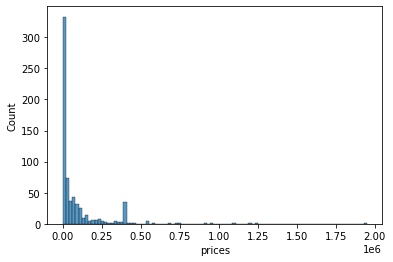

In [28]:
ax = sns.histplot(prices_to_add)
ax.set_xlabel('prices')

Se muestran los valores para un rango de precios entre 0 y 1000 

Text(0.5, 0, 'prices')

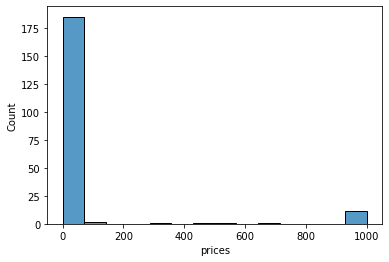

In [29]:
ax = sns.histplot(prices_to_add, bins=14,  binrange=(0,1000))
ax.set_xlabel('prices')
#ax.set(xlim=(0, 100000))
#ax.set(xlim=(0, 1000), ylim=(0,4000000))

Hay una gran cantidad de valores atipicos. Se calcula y dropea valores menores a 50 usd

In [30]:
print("cantidad de valores a dropear: {}".format((prices_to_add < 50).sum()))

cantidad de valores a dropear: 185


In [31]:
index_below_50 = prices_to_add[prices_to_add < 50].index
prices_to_add.drop(index=index_below_50,inplace=True)

Se muestra histograma de los datos a imputar habiendo eliminado estos valores atipicos

Text(0.5, 0, 'prices')

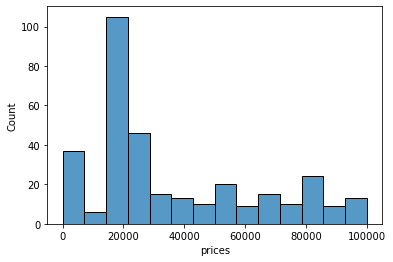

In [32]:
ax = sns.histplot(prices_to_add, bins=14, binrange=(0,100000))
ax.set_xlabel('prices')

Imputo valores al dataset

In [33]:
df.loc[prices_to_add.index,'price_aprox_usd'] = prices_to_add

**Imputacion por precio del metro cuadrado**

Se intenta imputar precios usando la columna de precio por m2

In [34]:
columns_m2 = ['price_aprox_usd', 'surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2', ]

Cantidad de propiedades que tienen price_usd_per_m2 y no tienen precio total

In [35]:
np.logical_and(df.price_usd_per_m2.notnull(), df.price_aprox_usd.isnull()).sum()

0

Cantidad de propiedades que tienen price_per_m2 y no tienen precio total

In [36]:
np.logical_and(df.price_per_m2.notnull(), df.price_aprox_usd.isnull()).sum()

0

No hay propiedades que tengan precio por m2 y no tengan precio total. No se puede imputar ningún valor de esta manera

<a id="section_outliers_price_columns"></a> 
## Objetivo 3: Outliers de precios

[volver a TOC](#section_toc)

Se inspecciona valores maximos y minimos de price_aprox_usd

In [37]:
df.sort_values(by='price_aprox_usd', ascending=False).head()

,property_type,place_name,place_with_parent_names,state_name,lat-lon,lat,lon,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,description,title
24548,apartment,San Telmo,|Argentina|Capital Federal|San Telmo|,Capital Federal,"-34.6213421,-58.3741846",-34.621342,-58.374185,46545445.00,200000.0,NaN,232.727225,NaN,NaN,3.0,NaN,dsdffhghvcvbcdfdfghdfhghkjhkhjklhjkfgvghfghnfg...,Departamento venta
91468,house,Punilla,|Argentina|Córdoba|Punilla|,Córdoba,NaN,NaN,NaN,25000000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Casa con Agua Corriente, Córdoba, Punilla, por...",Casa - Parque Siquiman
107390,house,San Roque,|Argentina|Mendoza|San Roque|,Mendoza,NaN,NaN,NaN,22980378.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Casa con Calefacción central, Mendoza, San Roq...",Casa - San Vicente
91479,house,Punilla,|Argentina|Córdoba|Punilla|,Córdoba,NaN,NaN,NaN,19500000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,\tCECILIA INMUEBLES OFRECE:INCREIBLE PROPIEDAD...,Casa - Parque Siquiman
91289,house,Punilla,|Argentina|Córdoba|Punilla|,Córdoba,NaN,NaN,NaN,16000000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"En Bv Artigas 876 , Parque Jardín, La Falda .A...",Casa - La Falda


In [38]:
df.sort_values(by='price_aprox_usd', ascending=True).head()

,property_type,place_name,place_with_parent_names,state_name,lat-lon,lat,lon,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,description,title
9761,house,Córdoba,|Argentina|Córdoba|,Córdoba,"4.5458426,-75.67893099",4.545843,-75.678931,0.0,NaN,NaN,NaN,NaN,2.0,3.0,NaN,Casa en Venta de 2 dorm. en Armenia,SE VENDE CASA EN EL BARRIO EL LIMONAR
66083,store,San Carlos de Bariloche,|Argentina|Río Negro|San Carlos de Bariloche|S...,Río Negro,NaN,NaN,NaN,88.0,NaN,22.0,NaN,NaN,NaN,NaN,NaN,"Local, San Carlos de Bariloche, San Carlos de ...",Edificio Comercial - San Carlos De Bariloche
77672,house,Neuquén,|Argentina|Neuquén|,Neuquén,"-40.799022,-71.597428",-40.799022,-71.597428,97.0,NaN,NaN,NaN,NaN,NaN,NaN,1356.0,TIEMPO COMPARTIDO: Cabaña para seis personas!E...,"Tiempo Compartido en Villa La Angostura, Oport..."
53856,house,Córdoba,|Argentina|Córdoba|Córdoba|,Córdoba,"-31.3036383166,-64.2410813336",-31.303638,-64.241081,350.0,1170.0,185.0,NaN,NaN,NaN,7.0,NaN,TERRA – VENDE CASA – COUNTRY SAN ISIDROMANZAN...,TERRA – VENDE CASA – COUNTRY SAN ISIDRO
108165,apartment,Puerto Madero,|Argentina|Capital Federal|Puerto Madero|,Capital Federal,"-34.6019675,-58.3640937",-34.601968,-58.364094,450.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CODIGO: 916-69184 ubicado en: VICTORIA OCAMPO ...,"Departamento en Venta en Puerto Madero, Capita..."


Calculo outliers con la cuenta del rango intercuartil

In [39]:
q1 = df['price_aprox_usd'].quantile(q = 0.25)
q3 = df['price_aprox_usd'].quantile(q = 0.75)
outliers_low = q3 + 1.5*(q3 - q1)
outliers_high = q1 - 1.5*(q3 - q1)

print('Umbral inferior: {}'.format(outliers_low))
print('Umbral superior: {}'.format(outliers_high))

Umbral inferior: 528550.0
Umbral superior: -174250.0


Los valores clásicos de outliers no estarían sirviendo, grafico histograma de precios

<AxesSubplot:xlabel='price_aprox_usd', ylabel='Count'>

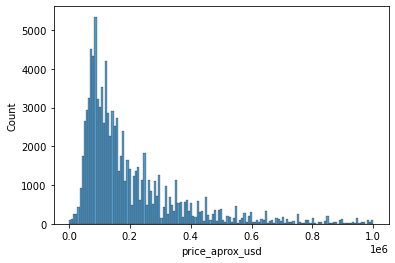

In [40]:
sns.histplot(df['price_aprox_usd'], binrange =(0,1000000))

La regla de outliers no funciona porque la distribución no es normal. Se revisa que porcentaje de una distribucion normal deja afuera la regla tradicional outliers. Luego se usa este procentaje como referencia en una distribución más acorde a lo obtenido

In [41]:
z_q1 = stats.norm.ppf(0.25)
z_q3 = stats.norm.ppf(0.75)
z_irq = z_q3 - z_q1
z_low_out = z_q1 - 1.5 * z_irq
z_low_high = z_q3 + 1.5 * z_irq
porc_low = stats.norm.cdf(z_low_out)
porc_high = stats.norm.cdf(z_low_high)

print('umbral inferior en porcentaje: {:.2}%'.format(porc_low))
print('umbral superior en porcentaje: {:.4}%'.format(porc_high))

umbral inferior en porcentaje: 0.0035%
umbral superior en porcentaje: 0.9965%


Pruebo distribución lognormal

In [42]:
price_aprox_usd_not_nulls = df.loc[df['price_aprox_usd'].notnull(), 'price_aprox_usd']
x=np.linspace(0,1000000,500)
(s_fit, loc_fit, scale_fit) = stats.lognorm.fit(price_aprox_usd_not_nulls)
lognormal_fitted = stats.lognorm.pdf(x, s_fit, loc=loc_fit, scale=scale_fit)

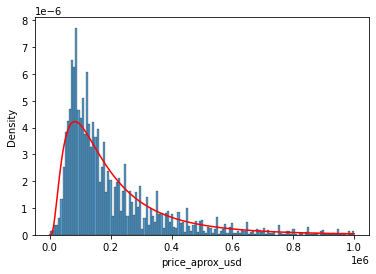

In [43]:
sns.histplot(price_aprox_usd_not_nulls, binrange =(0,1000000),stat='density')
plt.plot(x,lognormal_fitted,'r-')


Según la regla de outliers se deja un 0,35 % de la datos de una distribución normal afuera. Para este caso se será a ser un poco mas restrictivo y se dejará afuera un 1% de los datos de una distribución lognormal.

In [44]:
lognorm_low = stats.lognorm.ppf(0.01, s_fit, loc=loc_fit, scale=scale_fit)
lognorm_high = stats.lognorm.ppf(0.99, s_fit, loc=loc_fit, scale=scale_fit)

aux_low = price_aprox_usd_not_nulls < lognorm_low
aux_high = price_aprox_usd_not_nulls > lognorm_high
outliers_porc = (aux_low.sum() + aux_high.sum()) / len(price_aprox_usd_not_nulls)
print("Cantidad de datos que clasifico como outliers: {:.2}%".format(outliers_porc * 100) )

Cantidad de datos que clasifico como outliers: 2.8%


In [45]:
print('Umbral inferior lognormal: {}'.format(lognorm_low))
print('Umbral superior lognormal: {}'.format(lognorm_high))

Umbral inferior lognormal: 23454.092497037473
Umbral superior lognormal: 1074252.7126398406


Estos valores parecen razonables. Uso estos umbrales para eliminar outliers

Genero dataframe con la columna price sin nulos y sin outliers

In [46]:
mask_price_not_outliers = np.logical_and(df['price_aprox_usd']>lognorm_low, df['price_aprox_usd']<lognorm_high)
mask_price_not_nulls = df['price_aprox_usd'].notnull()
mask_price_tidy = np.logical_and(mask_price_not_outliers, mask_price_not_nulls)
df_price_tidy = df[mask_price_tidy].copy()

Porcentaje de filas del dataframe luego de quitar precios outliers y nulos con respecto al dataframe inicial

In [47]:
len(df_price_tidy['price_aprox_usd']) / len(df['price_aprox_usd']) * 100

81.20112192707474

In [48]:
#Guardo dataframe eliminar para entrega
df_price_tidy.to_csv('df_price_tidy.csv')

<a id="section_property_type_column"></a> 
## Columna Property_type

[volver a TOC](#section_toc)

Cantidad de nulos

In [49]:
print("Porcentaje de nulos: {0:.2f}%".format(100*df.property_type.isnull().sum()/len(df.property_type)))

Porcentaje de nulos: 0.00%


In [50]:
df.property_type.value_counts()

apartment    71065
house        40268
PH            5751
store         4136
Name: property_type, dtype: int64

La columna "property_type" esta correctamente ingresada. No es necesario modificarla

**Se grafica con bloxpot para visualizar el aporte de esta columna**

**NOTA: tener en cuenta que la distribución de precios no es normal y tampoco es simétrica al momento de visualizar el boxplot**

[(0.0, 1000000.0)]

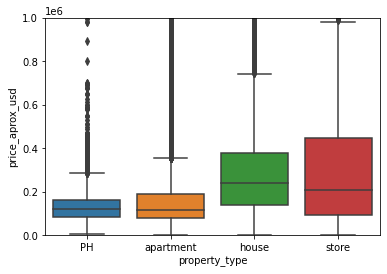

In [51]:
ax = sns.boxplot(x = 'property_type', y='price_aprox_usd', data = df)
ax.set(ylim=(0, 1000000))

Se vuelve a graficar habiendo limpiando la columna de precios.

[(0.0, 1000000.0)]

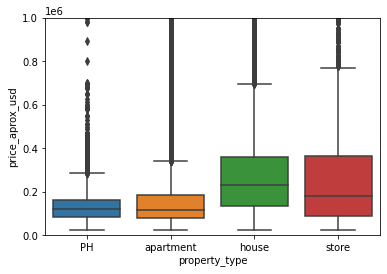

In [52]:
ax = sns.boxplot(x = 'property_type', y='price_aprox_usd', data = df_price_tidy)
ax.set(ylim=(0, 1000000))

<a id="section_room_column"></a> 
## Columna room

[volver a TOC](#section_toc)


**Porcentaje de nulos**

In [53]:
print("Procentaje de nulos: {}%".format(100*df.rooms.isnull().sum()/len(df.rooms)))

Procentaje de nulos: 60.90579112357697%


**Grafico boxplot para visualizar aporte de esta columna**

[(0.0, 1000000.0)]

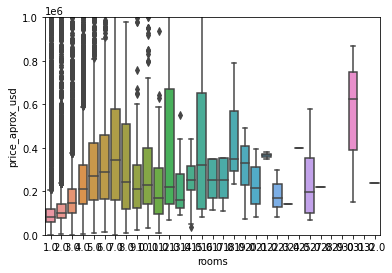

In [54]:
ax = sns.boxplot(x = 'rooms', y='price_aprox_usd', data = df)
ax.set(ylim=(0, 1000000))

In [55]:
np.sort(df.rooms.unique())

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 27.,
       28., 29., 30., 31., 32., nan])

In [56]:
df.rooms.value_counts()

3.0     12567
2.0     12433
4.0      7937
1.0      7377
5.0      3782
6.0      1403
7.0       770
8.0       409
10.0      226
9.0       184
11.0       72
12.0       65
13.0       33
14.0       27
15.0       26
17.0       16
16.0       11
20.0       11
22.0        8
18.0        6
21.0        5
30.0        4
25.0        4
19.0        4
32.0        3
23.0        2
24.0        1
27.0        1
29.0        1
31.0        1
28.0        1
Name: rooms, dtype: int64

Hay una gran cantidad de valores diferentes para "rooms" pero solo algunos valores presentan una cantidad relevante de entradas.

In [57]:
print("porcentaje de casas con mas de 10 rooms: {:.2f}%".format(100*(df['rooms']>10).sum()/ len(df['rooms'])))

porcentaje de casas con mas de 10 rooms: 0.25%


In [58]:
print("porcentaje de casas con mas de 7 rooms: {:.2f}%".format(100*(df['rooms']>7).sum()/ len(df['rooms'])))

porcentaje de casas con mas de 7 rooms: 0.92%


In [59]:
print("porcentaje de casas con mas de 5 rooms: {:.2f}%".format(100*(df['rooms']>5).sum()/ len(df['rooms'])))

porcentaje de casas con mas de 5 rooms: 2.72%


Se repite gráfico boxplot considerando las propiedades con rooms < 7.

[(0.0, 1000000.0)]

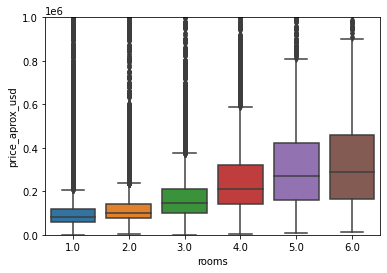

In [60]:
ax = sns.boxplot(x = 'rooms', y='price_aprox_usd', data = df[df.rooms<7])
ax.set(ylim=(0, 1000000))

Parece aportar información. Por la cantidad de nulos se podria ver de obtener valores a partir de las columnas description y title.

<a id="section_impute_rooms_columns"></a> 
## Imputacion de rooms

[volver a TOC](#section_toc)

Se usa regex para obtener valores de rooms mediante las columnas description y title.

Primero se busca por ambientes:

In [61]:
#Función para buscar patrones de cantidad de ambientes
def amb_regex(x):
    if not isinstance(x, str):
        return np.NaN
    x = x.lower()
    patron_amb = "((?P<numero_amb>\d*\d)\s*(amb|ambientes))"
    patron_amb_regex = re.compile(patron_amb)
    
    search = patron_amb_regex.search(x)
    if (search is not None):
        return int(search.group('numero_amb'))
    else:
        return np.NaN

In [62]:
#Para buscar valores de ambientes utilizo el dataframe original
mask_rooms_null = df['rooms'].isnull()
data_roomsnull = df.loc[mask_rooms_null].copy()
title_result = df['title'].apply(amb_regex)
description_result = df['description'].apply(amb_regex)

In [63]:
mask_title_and_description = np.logical_or(description_result.notnull(), title_result.notnull())
mask_title_and_description = np.logical_and(mask_title_and_description, mask_rooms_null)
print("Valores imputados con regex: {}".format(mask_title_and_description.sum()))

Valores imputados con regex: 21790


Se combinan ambas series de valores en una:

In [64]:
def union(x):
    if not np.isnan(x['title']):
        return x['title']
    
    if not np.isnan(x['description']):
        return x['description']
    
    return np.NaN

df_description_title = pd.merge(description_result, title_result, right_index=True, left_index=True)
result_amb_regex = df_description_title.apply(union, axis=1)

Se inspecciona la dataseries resultante

In [65]:
result_amb_regex[mask_rooms_null].value_counts().head(10)

3.0     7084
2.0     7073
4.0     4291
5.0     1344
1.0     1328
6.0      416
7.0      157
8.0       32
9.0       16
11.0       8
dtype: int64

In [66]:
(result_amb_regex[mask_rooms_null] <= 10).sum() / result_amb_regex[mask_rooms_null].notnull().sum()

0.9981184029371272

Las propiedades con 10 o menos ambientes abarcan cerca del 99.8% de la valores de ambientes encontrados. Se utilizan estos valores para imputar

In [67]:
mask_amb_below_11 = result_amb_regex < 11
mask_rooms_null_amb_below_11 = np.logical_and(mask_amb_below_11, mask_rooms_null )
df.loc[mask_rooms_null_amb_below_11,'rooms'] = result_amb_regex[mask_rooms_null_amb_below_11]

Se aplica lo mismo para el dataframe que se habian limpiado los valores de precios

In [68]:
mask_rooms_null = df_price_tidy['rooms'].isnull()
data_roomsnull = df_price_tidy.loc[mask_rooms_null].copy()
title_result = df_price_tidy['title'].apply(amb_regex)
description_result = df_price_tidy['description'].apply(amb_regex)

mask_title_and_description = np.logical_or(description_result.notnull(), title_result.notnull())
mask_title_and_description = np.logical_and(mask_title_and_description, mask_rooms_null)

df_description_title = pd.merge(description_result, title_result, right_index=True, left_index=True)
result_amb_regex = df_description_title.apply(union, axis=1)

mask_amb_below_11 = result_amb_regex < 11
mask_rooms_null_amb_below_11 = np.logical_and(mask_amb_below_11, mask_rooms_null )
df_price_tidy.loc[mask_rooms_null_amb_below_11,'rooms'] = result_amb_regex[mask_rooms_null_amb_below_11]

Se prueba de imputar rooms buscando dormitorios. Para ver si tiene sentido imputar de esta manera se busca las propiedades que tienen valores rooms y que presentan cantidad de dormitorios en description o title, y se contrastan estos valores:

In [69]:
#Función para buscar patrones de cantidad de dormitorios
def dorm_regex(x):
    if not isinstance(x, str):
        return np.NaN
    x = x.lower()
    
    patron_dorm = "((?P<numero_dorm>\d*\d)\s*(dormitorios|dorm))"
    patron_dorm_regex = re.compile(patron_dorm)
    
    search = patron_dorm_regex.search(x)
    if (search is not None):
        return int(search.group('numero_dorm'))
    
    else:
        return np.NaN

In [70]:
title_regex_dorm = df['title'].apply(dorm_regex)
description_regex_dorm = df['description'].apply(dorm_regex)
df_description_title_dorm = pd.merge(description_regex_dorm, title_regex_dorm, right_index=True, left_index=True)
result_dorm_regex = df_description_title_dorm.apply(union, axis=1)

df_prueba_dorm = df.copy()
df_prueba_dorm['union'] =  result_dorm_regex
df_dorm_groupby = df_prueba_dorm.groupby(by = 'rooms')
df_dorm_groupby['union'].median().head(15)

rooms
1.0     1.0
2.0     1.0
3.0     2.0
4.0     3.0
5.0     3.0
6.0     3.0
7.0     3.0
8.0     3.0
9.0     3.0
10.0    3.0
11.0    3.0
12.0    4.0
13.0    3.0
14.0    3.0
15.0    3.0
Name: union, dtype: float64

En la tabla de arriba se presentan los valores de la mediana de los dormitorios encontrados con regex agrupados según el valor de room de las propiedades. Se encuentra que no hay una relación marcada entre rooms y dormitorios, y por lo tanto no se imputa con estos valores.

<a id="section_m2_columns"></a> 
## Columnas m2 y precio por m2

[volver a TOC](#section_toc)

**Se grafica precio vs superficie para ver aporte de estas columnas**

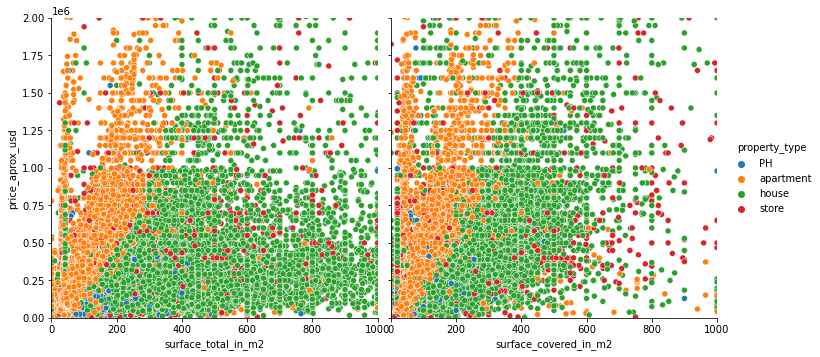

In [71]:
ax =sns.pairplot(df, hue='property_type', x_vars = ['surface_total_in_m2','surface_covered_in_m2'] , y_vars = 'price_aprox_usd', height=5, diag_kind = None);
ax.set(xlim=(0, 1000), ylim=(0,2000000))

Covarianzas entre precio y superficies

In [72]:
df[['price_aprox_usd', 'surface_covered_in_m2', 'surface_total_in_m2']].corr()

,price_aprox_usd,surface_covered_in_m2,surface_total_in_m2
price_aprox_usd,1.000000,0.165536,0.293830
surface_covered_in_m2,0.165536,1.000000,0.195453
surface_total_in_m2,0.293830,0.195453,1.000000


Sacando outliers y trabajando mejor las columnas parece que podrian aportar información.

**Porcentaje de nulos**

In [73]:
print("Procentaje de nulos surface_total: {}%".format(100*df.surface_total_in_m2.isnull().sum()/len(df.rooms)))
print("Procentaje de nulos surface_covered: {}%".format(100*df.surface_covered_in_m2.isnull().sum()/len(df.rooms)))
print("Procentaje de nulos price_usd_per_m2: {}%".format(100*df.price_usd_per_m2.isnull().sum()/len(df.rooms)))
print("Procentaje de nulos price_per_m2: {}%".format(100*df.price_per_m2.isnull().sum()/len(df.rooms)))

Procentaje de nulos surface_total: 32.44349117307375%
Procentaje de nulos surface_covered: 16.422207556508827%
Procentaje de nulos price_usd_per_m2: 43.394654347467416%
Procentaje de nulos price_per_m2: 27.686850354726943%


**Busco relacion entre las columnas de m2 y de precio por m2**

Se grafica histograma de: price_per_m2 * surface_covered_in_m2 / precio_aprox_usd:

<AxesSubplot:ylabel='Count'>

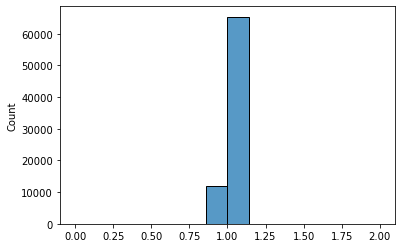

In [74]:
price_usd_calculated = df['price_per_m2'] * df['surface_covered_in_m2']
ratio_prices = price_usd_calculated/df['price_aprox_usd']
sns.histplot(ratio_prices, bins=14, binrange=(0,2))

Grafico histograma de: price_usd_per_m2 * surface_total_in_m2 / precio_aprox_usd

In [75]:
price_usd_calculated = df['price_usd_per_m2'] * df['surface_total_in_m2']
ratio_prices = price_usd_calculated/df['price_aprox_usd']

<AxesSubplot:ylabel='Count'>

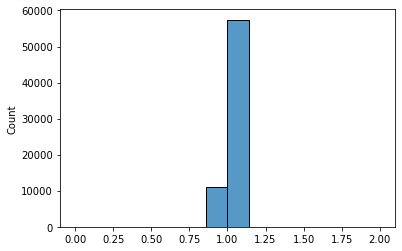

In [76]:
sns.histplot(ratio_prices, bins=14, binrange=(0,2))

De acuerdo a los dos histogramas se cumplió lo siguiente:
* price_usd_per_m2 = price_aprox_usd / surface_total_in_m2
* price_per_m2 = price_aprox_usd / surface_covered_in_m2
    

Las columnas de precio por m2 no aportan información. Se obtienen a partir de la columna de precio y las columnas de superficie. En base a esto se eliminan las columnas de precio por m2.

***Debido a la cantidad de valores nulos de las columnas habria que estudiar la posibilidad de imputar valores utilizando otras columnas, por ejemplo description y title***

<a id="section_impute_m2_columns"></a> 
## Imputacion de superficie

[volver a TOC](#section_toc)

Se busca imputar valores de superficie cubierta usando la columna rooms.

Primero se revisa cuantas propiedades hay que tengan rooms y no tengan superficie cubierta.

In [77]:
mask_rooms_notnull = df_price_tidy['rooms'].notnull()
mask_surface_covered_null = df_price_tidy['surface_covered_in_m2'].isnull()
mask_rooms_null_surface_notnull = np.logical_and(mask_rooms_notnull, mask_surface_covered_null)
print('Cantidad de propiedades: {}'.format(mask_rooms_null_surface_notnull.sum()))
df_price_tidy.loc[mask_rooms_null_surface_notnull, 'rooms'].value_counts()

Cantidad de propiedades: 5774


2.0     1873
3.0     1813
4.0      840
1.0      668
5.0      325
6.0      122
7.0       51
8.0       33
10.0      18
9.0       10
11.0       6
14.0       4
15.0       3
13.0       3
12.0       2
16.0       1
20.0       1
19.0       1
Name: rooms, dtype: int64

Se grafica la superficies para propiedades con 2 rooms y apartments.

<AxesSubplot:xlabel='surface_covered_in_m2', ylabel='Count'>

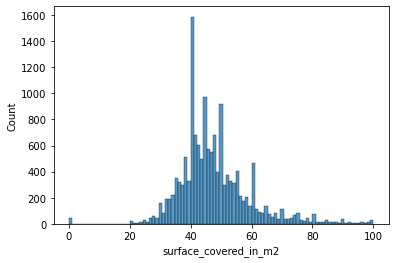

In [78]:
#Trabajo con el dataframe original
mask_apartment = df['property_type'] == 'apartment'
mask_2_rooms = df['rooms'] == 2
mask_apartment_and_2rooms = np.logical_and(mask_apartment,mask_2_rooms)
surface_covered_2rooms = df.loc[mask_apartment_and_2rooms, 'surface_covered_in_m2']
sns.histplot(surface_covered_2rooms, binrange=(0,100))

In [79]:
mask_surface_below_55 = df['surface_covered_in_m2'] < 55
mask_surface_above_35 = df['surface_covered_in_m2'] > 35
mask_surface_between_35_55 = np.logical_and(mask_surface_below_55, mask_surface_above_35)
mask_2rooms_surface_35_55 = np.logical_and(mask_surface_between_35_55, mask_2_rooms)
proporcion_2_rooms_surface_35_55 = mask_2rooms_surface_35_55.sum() / mask_2_rooms.sum()
print('Porcentaje de propiedades con superfices entre 35 m2 y 55 m2: {}'.format(proporcion_2_rooms_surface_35_55))

Porcentaje de propiedades con superfices entre 35 m2 y 55 m2: 0.5599302778632216


Se calcula la mediana de la superficie cubierta para departamentos agrupando por rooms.

In [80]:
mask_apartment = df['property_type'] == 'apartment'
mask_rooms_below_7 = df['rooms'] < 7
mask_apartment_and_rooms_below_7 = np.logical_and(mask_apartment, mask_rooms_below_7)
df_groupby_property = df[mask_apartment_and_rooms_below_7].groupby('rooms')
df_groupby_property['surface_covered_in_m2'].median()

rooms
1.0     34.0
2.0     46.0
3.0     70.0
4.0     99.0
5.0    153.0
6.0    185.0
Name: surface_covered_in_m2, dtype: float64

El caso analizado presentó una dispersión considerable de la superficie por lo que imputar de esta manera puede ocasionar errores significativos. Debido a esto no se imputa de esta manera por el momento, dejándose para un futuro análisis con más profundidad.

<a id="outliers_m2_columns"></a> 
## Outliers de superficie

[volver a TOC](#section_toc)

Se grafica distribución de surface_covered_in_m2:

<AxesSubplot:xlabel='surface_covered_in_m2', ylabel='Count'>

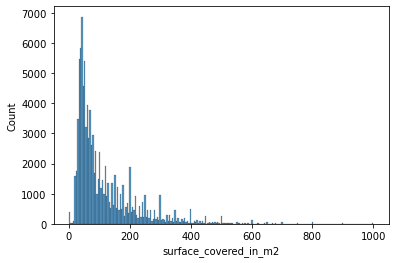

In [81]:
surface_covered_not_nulls = df.loc[df['surface_covered_in_m2'].notnull(), 'surface_covered_in_m2']
sns.histplot(surface_covered_not_nulls, binrange=[0,1000])

Se fitea lognormal y se calculan los valores umbrales dejando afuera el 1% de la distribución para cada uno de los lados:

In [82]:
x=np.linspace(0,1000,500)
(s_fit, loc_fit, scale_fit) = stats.lognorm.fit(surface_covered_not_nulls)
lognormal_fitted = stats.lognorm.pdf(x, s_fit, loc=loc_fit, scale=scale_fit)

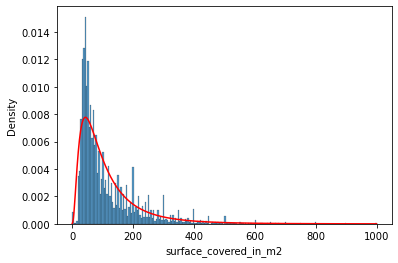

In [83]:
sns.histplot(df['surface_covered_in_m2'], binrange =(0,1000),stat='density')
plt.plot(x,lognormal_fitted,'r-')

In [84]:
surface_covered_lognorm_low = stats.lognorm.ppf(0.01, s_fit, loc=loc_fit, scale=scale_fit)
surface_covered_lognorm_high = stats.lognorm.ppf(0.99, s_fit, loc=loc_fit, scale=scale_fit)

aux_low = surface_covered_not_nulls < surface_covered_lognorm_low
aux_high = surface_covered_not_nulls > surface_covered_lognorm_high
surface_covered_outliers_porc = (aux_low.sum() + aux_high.sum()) / len(surface_covered_not_nulls)

print('Umbral inferior: {:.4} m2'.format(surface_covered_lognorm_low))
print('Umbral superior: {:.4} m2'.format(surface_covered_lognorm_high))
print("Cantidad de datos que clasifico como outliers: {:.2}%".format(surface_covered_outliers_porc * 100) )

Umbral inferior: 11.0 m2
Umbral superior: 570.7 m2
Cantidad de datos que clasifico como outliers: 1.7%


Se crea un dataframe que tengra price_aprox_usd y surface_covered sin nulos y sin outliers.

In [85]:
mask_surface_covered_not_outliers = np.logical_and(
    df_price_tidy['surface_covered_in_m2'] > surface_covered_lognorm_low, 
    df_price_tidy['surface_covered_in_m2'] < surface_covered_lognorm_high)
mask_surface_covered_not_nulls = df_price_tidy['surface_covered_in_m2'].notnull()
mask_surface_tidy = np.logical_and(mask_surface_covered_not_outliers, 
                                   mask_surface_covered_not_nulls)
df_price_surface_tidy = df_price_tidy[mask_surface_tidy].copy()

Porcentaje del dataframe con price_aprox_usd y surface_covered sin outliers y sin nulos con respecto al dataframe original:

In [86]:
df_price_surface_tidy.shape[0] / df.shape[0] * 100

69.95132816366936

<a id="section_geo_columns"></a> 
## Columnas de ubicacion geografica

[volver a TOC](#section_toc)

In [87]:
geographic_columns = ['place_name','place_with_parent_names','state_name','lat-lon','lat','lon']
df_price_surface_tidy[geographic_columns].head()

,place_name,place_with_parent_names,state_name,lat-lon,lat,lon
0,Mataderos,|Argentina|Capital Federal|Mataderos|,Capital Federal,"-34.6618237,-58.5088387",-34.661824,-58.508839
2,Mataderos,|Argentina|Capital Federal|Mataderos|,Capital Federal,"-34.6522615,-58.5229825",-34.652262,-58.522982
4,Centro,|Argentina|Buenos Aires Costa Atlántica|Mar de...,Buenos Aires Costa Atlántica,"-38.0026256,-57.5494468",-38.002626,-57.549447
6,Munro,|Argentina|Bs.As. G.B.A. Zona Norte|Vicente Ló...,Bs.As. G.B.A. Zona Norte,"-34.5329567,-58.5217825",-34.532957,-58.521782
7,Belgrano,|Argentina|Capital Federal|Belgrano|,Capital Federal,"-34.5598729,-58.443362",-34.559873,-58.443362


Se calcula la cantidad de valores nulos como porcentaje del total de valores:

In [88]:
df_price_surface_tidy[geographic_columns].isnull().sum() / df_price_surface_tidy[geographic_columns].shape[0]*100

place_name                  0.023586
place_with_parent_names     0.000000
state_name                  0.000000
lat-lon                    41.574385
lat                        41.574385
lon                        41.574385
dtype: float64

Las columnas de latitud y longitud tienen una gran cantidad de valores nulos, y por lo tanto muchas posibilidades de ser descartadas.
Las columnas place_name y state_name parecen ser generadas a partir de place_with_parent_names y ésta parece tener varios niveles

Se inspeccionan los valores de place_with_parent_names que incluyen a Mar del Plata.

In [89]:
df_mar_del_plata = df_price_surface_tidy['place_with_parent_names'].apply(lambda x: x if 'Mar del Plata' in x else np.NaN)
df_mar_del_plata.value_counts().head(10)

|Argentina|Buenos Aires Costa Atlántica|Mar del Plata|                 4302
|Argentina|Buenos Aires Costa Atlántica|Mar del Plata|Centro|           170
|Argentina|Buenos Aires Costa Atlántica|Mar del Plata|Plaza Mitre|      100
|Argentina|Buenos Aires Costa Atlántica|Mar del Plata|Güemes|            73
|Argentina|Buenos Aires Costa Atlántica|Mar del Plata|Constitución|      71
|Argentina|Buenos Aires Costa Atlántica|Mar del Plata|Chauvín|           68
|Argentina|Buenos Aires Costa Atlántica|Mar del Plata|La Perla|          55
|Argentina|Buenos Aires Costa Atlántica|Mar del Plata|Playa Grande|      50
|Argentina|Buenos Aires Costa Atlántica|Mar del Plata|Plaza Colón|       42
|Argentina|Buenos Aires Costa Atlántica|Mar del Plata|Playa Chica|       27
Name: place_with_parent_names, dtype: int64

La mayoria de los valores termina en el nivel de Mar del Plata pero hay valores que tienen un nivel más y especifican zonas dentro de Mar del Plata.
Se asume que esto se repite para todas las localidades y se crea una nueva columna llamada place que va a contener place_with_parent_names pero recortado hasta el tercer nivel.

Por ejemplo todas las entradas que son de Mar del Plata van a decir lo siguiente: |Argentina|Buenos Aires Costa Atlántica|Mar del Plata|

Los valores que no tengan un tercer nivel quedarán como nulos

In [90]:
def create_place(s):
    string_split = s.split('|')
    if len(string_split) >= 5:
        result = '|'.join(string_split[1:4])
        return result
    else:
        return np.NaN
    
df_price_surface_tidy['place'] = df_price_surface_tidy['place_with_parent_names'].apply(create_place)

In [91]:
print('{} places nulos de {}'.format(df_price_surface_tidy['place'].isnull().sum(),df_price_surface_tidy.shape[0]))

2767 places nulos de 84795


Se eliminan los valores nulos de place

In [92]:
mask_place_notnull = df_price_surface_tidy['place'].notnull()
df_price_surface_place_tidy = df_price_surface_tidy[mask_place_notnull].copy()

<a id="section_precio_m2_place"></a> 
## Precio por metro cuadrado por zona

[volver a TOC](#section_toc)

Como manera para considerar la valoración de la zona en el precio de las propiedades se calcula el precio por metro cuadrado para cada zona. Además se calcula la correlación entre precio y superficie para brindar un parametro que permita obtener las zonas donde esta relación es mejor.

**Paso 1: se dropean columnas de precio por metro cuadrado y se crean de nuevo para asegurarse que estén bien hechas**

In [93]:
df_price_surface_tidy.dtypes

property_type               object
place_name                  object
place_with_parent_names     object
state_name                  object
lat-lon                     object
lat                        float64
lon                        float64
price_aprox_usd            float64
surface_total_in_m2        float64
surface_covered_in_m2      float64
price_usd_per_m2           float64
price_per_m2               float64
floor                      float64
rooms                      float64
expenses                   float64
description                 object
title                       object
place                       object
dtype: object

In [94]:
columns_to_drop = ['price_usd_per_m2', 'price_per_m2']
df_price_surface_tidy.drop(columns = columns_to_drop, inplace=True)

In [95]:
df_price_surface_tidy.dtypes

property_type               object
place_name                  object
place_with_parent_names     object
state_name                  object
lat-lon                     object
lat                        float64
lon                        float64
price_aprox_usd            float64
surface_total_in_m2        float64
surface_covered_in_m2      float64
floor                      float64
rooms                      float64
expenses                   float64
description                 object
title                       object
place                       object
dtype: object

Se arma columna de precio por m2

In [96]:
df_price_surface_place_tidy['price_per_m2'] = df_price_surface_place_tidy['price_aprox_usd'] / df_price_surface_place_tidy['surface_covered_in_m2']

**Paso 2: se agrupa por place y se calcula el valor promedio del precio por metro cuadrado para cada zona**

Primero se considera una ciudad con cierta cantidad de propiedades, en este caso Pilar, y se ve cómo es la distribución del precio por m2

In [97]:
place = 'Argentina|Bs.As. G.B.A. Zona Norte|Pilar'
mask_pilar = df_price_surface_place_tidy['place'] == place
price_pilar = df_price_surface_place_tidy.loc[mask_pilar, 'price_aprox_usd']
surface_pilar = df_price_surface_place_tidy.loc[mask_pilar, 'surface_covered_in_m2']
price_per_m2_pilar = price_pilar / surface_pilar

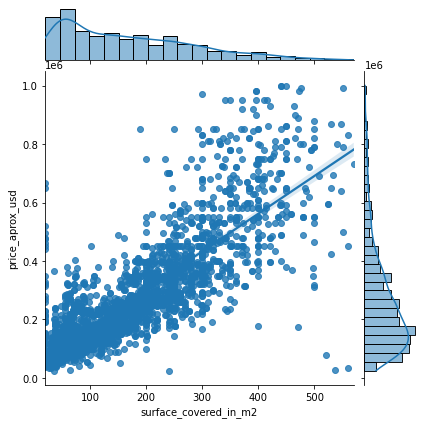

In [98]:
ax = sns.jointplot(x=surface_pilar, y=price_pilar, kind="reg")

Text(0.5, 1.0, 'Pilar')

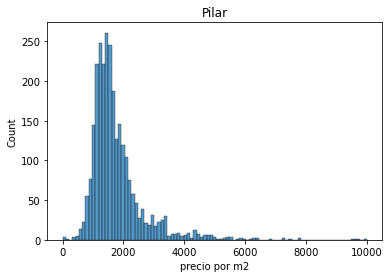

In [99]:
ax = sns.histplot(price_per_m2_pilar, binrange=[0,10000])
ax.set_xlabel('precio por m2')
ax.set_title('Pilar')

In [100]:
price_per_m2_pilar.median()

1551.7241379310344

In [101]:
price_per_m2_pilar.mean()

1902.2315866249332

La distribución tiene asimetria positiva y por lo tanto median < mean.

El valor más adecuado para calcular un valor medio seria el de la moda pero como es una variable continua se utiliza la mediana 

Se crea un dataseries que tenga como indice el lugar('place') y como valor el precio por metro cuadrado de ese lugar, usando la mediana para calcular este valor

In [102]:
df_tidy_groupby = df_price_surface_place_tidy.groupby('place')
ds_place_price_per_m2 = df_tidy_groupby['price_per_m2'].median()
ds_place_price_per_m2

place
Argentina|Bs.As. G.B.A. Zona Norte|Escobar                1403.893520
Argentina|Bs.As. G.B.A. Zona Norte|General San Martín     1415.662651
Argentina|Bs.As. G.B.A. Zona Norte|José C Paz              924.285714
Argentina|Bs.As. G.B.A. Zona Norte|Malvinas Argentinas    1360.000000
Argentina|Bs.As. G.B.A. Zona Norte|Pilar                  1551.724138
                                                             ...     
Argentina|Tierra Del Fuego|Río Grande                     1343.671354
Argentina|Tierra Del Fuego|Ushuaia                        2000.000000
Argentina|Tucumán|San Miguel de Tucumán                   1453.153134
Argentina|Tucumán|Tafí del Valle                           486.058467
Argentina|Tucumán|Yerba Buena                             1215.146292
Name: price_per_m2, Length: 421, dtype: float64

In [103]:
ds_place_price_per_m2.head(10)

place
Argentina|Bs.As. G.B.A. Zona Norte|Escobar                1403.893520
Argentina|Bs.As. G.B.A. Zona Norte|General San Martín     1415.662651
Argentina|Bs.As. G.B.A. Zona Norte|José C Paz              924.285714
Argentina|Bs.As. G.B.A. Zona Norte|Malvinas Argentinas    1360.000000
Argentina|Bs.As. G.B.A. Zona Norte|Pilar                  1551.724138
Argentina|Bs.As. G.B.A. Zona Norte|San Fernando           2100.000000
Argentina|Bs.As. G.B.A. Zona Norte|San Isidro             2200.000000
Argentina|Bs.As. G.B.A. Zona Norte|San Miguel             1496.268657
Argentina|Bs.As. G.B.A. Zona Norte|Tigre                  2214.285714
Argentina|Bs.As. G.B.A. Zona Norte|Vicente López          2558.139535
Name: price_per_m2, dtype: float64

**Paso 3: se agrupa por place y se calcula la cantidad de propiedades**

In [104]:
ds_place_count = df_tidy_groupby['price_per_m2'].count()
ds_place_count

place
Argentina|Bs.As. G.B.A. Zona Norte|Escobar                1604
Argentina|Bs.As. G.B.A. Zona Norte|General San Martín     1273
Argentina|Bs.As. G.B.A. Zona Norte|José C Paz               78
Argentina|Bs.As. G.B.A. Zona Norte|Malvinas Argentinas     385
Argentina|Bs.As. G.B.A. Zona Norte|Pilar                  2761
                                                          ... 
Argentina|Tierra Del Fuego|Río Grande                       15
Argentina|Tierra Del Fuego|Ushuaia                           5
Argentina|Tucumán|San Miguel de Tucumán                     71
Argentina|Tucumán|Tafí del Valle                             3
Argentina|Tucumán|Yerba Buena                               11
Name: price_per_m2, Length: 421, dtype: int64

**Paso 4: Se agrupa por place y se calcula el valor de la correlacion entre el precio y la superficie**

Esta puede ser una medida de que tan bueno es el cálculo del precio por metro cuadrado para cada place

In [105]:
places = list(ds_place_count.index)
corrs = []
for place in places:
    mask_place = df_price_surface_place_tidy['place'] == place
    price = df_price_surface_place_tidy.loc[mask_place,'price_aprox_usd']
    surface = df_price_surface_place_tidy.loc[mask_place,'surface_covered_in_m2']
    correlacion = np.corrcoef(price, surface)[0,1]
    corrs.append(correlacion)

D:\anaconda3\envs\dhdsblend2021\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
D:\anaconda3\envs\dhdsblend2021\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
D:\anaconda3\envs\dhdsblend2021\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
D:\anaconda3\envs\dhdsblend2021\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
D:\anaconda3\envs\dhdsblend2021\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [106]:
ds_place_corr = pd.Series(corrs, index=places)
ds_place_corr.head(10)

Argentina|Bs.As. G.B.A. Zona Norte|Escobar                0.715120
Argentina|Bs.As. G.B.A. Zona Norte|General San Martín     0.683359
Argentina|Bs.As. G.B.A. Zona Norte|José C Paz             0.343358
Argentina|Bs.As. G.B.A. Zona Norte|Malvinas Argentinas    0.848762
Argentina|Bs.As. G.B.A. Zona Norte|Pilar                  0.828547
Argentina|Bs.As. G.B.A. Zona Norte|San Fernando           0.783057
Argentina|Bs.As. G.B.A. Zona Norte|San Isidro             0.801725
Argentina|Bs.As. G.B.A. Zona Norte|San Miguel             0.784846
Argentina|Bs.As. G.B.A. Zona Norte|Tigre                  0.828267
Argentina|Bs.As. G.B.A. Zona Norte|Vicente López          0.723460
dtype: float64

Grafico correlacion entre precio y superfice vs cant de propiedades

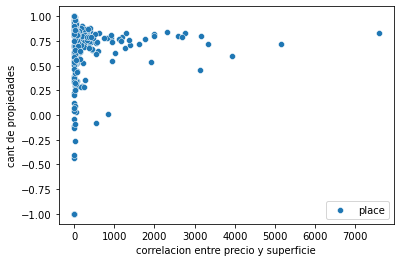

In [107]:
places = list(ds_place_count.index)
ax = sns.scatterplot(x = ds_place_count[places], y = ds_place_corr[places], label='place')
ax.set_ylabel('cant de propiedades')
ax.set_xlabel('correlacion entre precio y superficie')
ax.legend(loc='lower right')

**Paso 5: Se obtienen las ciudades con precios por metro cuadrado más representativos**

Se obtienen las ciudades que tiene una correlación entre precio y superficie mayor a 0.75.

In [108]:
mask = ds_place_corr > 0.75
places_well_corr = ds_place_corr[mask].index

In [109]:
# Proporción de places correlacionadas con respecto a la cantidad total de places
places_well_corr.shape[0] / ds_place_corr.shape[0]

0.4180522565320665

In [110]:
# proporción de propiedades correlacionadas con respecto a la cantidad total de places
ds_place_count[places_well_corr].sum() / ds_place_count.sum()

0.5621982737601795

**Gráfico para mostrar resultados**

Se genera grafico precio vs superficie * precio por m2 de la zona, para todas las propiedades del dataset.

Se considera solo los departamentos

In [111]:
mask_places = df_price_surface_place_tidy['place'].apply(lambda x: True if x in list(places_well_corr) else False)
mask_apartments = df_price_surface_place_tidy['property_type'] == 'apartment'
mask_places_apartment = np.logical_and(mask_places, mask_apartments)
df_places_well_corr = df_price_surface_place_tidy[mask_places_apartment]
price = df_places_well_corr['price_aprox_usd']
price_est = df_places_well_corr.apply(lambda x: x['surface_covered_in_m2'] * ds_place_price_per_m2[x['place']], axis = 1 )

Correlacion precio vs superficie * precio por m2 de la zona, para departamentos

In [112]:
np.corrcoef(price, price_est)

array([[1.        , 0.84934716],
       [0.84934716, 1.        ]])

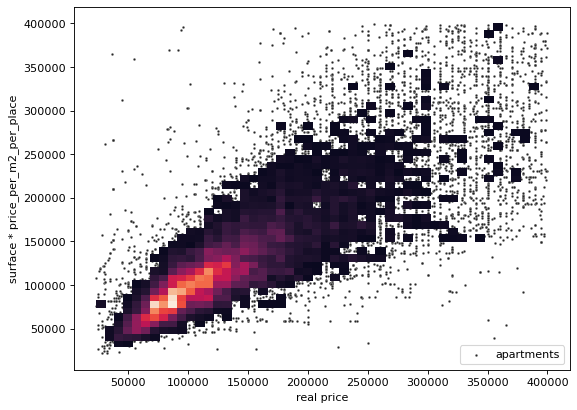

In [113]:
#Recorto precios a maximo 40k para poder ver el grafico sin tener que ajustar los ejes.
#Ya que se pierde resolucion en el grafico si tengo que hacer zoom
mask_price_below_40k = price < 400000
mask_price_est_below_40k = price_est < 400000
mask_prices_below_40k = np.logical_and(mask_price_below_40k, mask_price_est_below_40k)
price_redux = price[mask_prices_below_40k]
price_est_redux = price_est[mask_prices_below_40k]

x = price_redux
y = price_est_redux
plt.figure(figsize=(8, 6), dpi=80)
ax = plt.axes()
sns.scatterplot(x=x, y=y, s=5, color=".15", ax=ax, label='apartments')
sns.histplot(x=x, y=y, bins=50, pthresh=.1, cmap='rocket', ax=ax)
ax.set_xlabel('real price')
ax.set_ylabel('surface * price_per_m2_per_place')
ax.legend()

Se repite gráfico considerando sólo casas

In [114]:
mask_places = df_price_surface_place_tidy['place'].apply(lambda x: True if x in list(places_well_corr) else False)
mask_apartments = df_price_surface_place_tidy['property_type'] == 'house'
mask_places_apartment = np.logical_and(mask_places, mask_apartments)
df_places_well_corr = df_price_surface_place_tidy[mask_places_apartment]
price = df_places_well_corr['price_aprox_usd']
price_est = df_places_well_corr.apply(lambda x: x['surface_covered_in_m2'] * ds_place_price_per_m2[x['place']], axis = 1 )

In [115]:
np.corrcoef(price, price_est)

array([[1.        , 0.80836649],
       [0.80836649, 1.        ]])

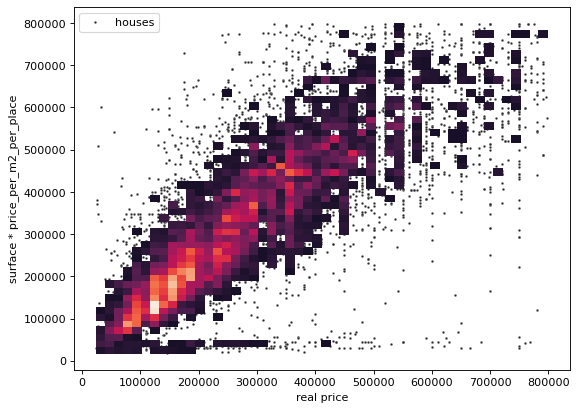

In [116]:
#Recorto precios a maximo 80k para poder ver el grafico sin tener que ajustar los ejes.
#Ya que se pierde resolucion en el grafico si tengo que hacer zoom
mask_price_below_80k = price < 800000
mask_price_est_below_80k = price_est < 800000
mask_prices_below_80k = np.logical_and(mask_price_below_80k, mask_price_est_below_80k)
price_redux = price[mask_prices_below_80k]
price_est_redux = price_est[mask_prices_below_80k]

x = price_redux
y = price_est_redux
plt.figure(figsize=(8, 6), dpi=80)
ax = plt.axes()
sns.scatterplot(x=x, y=y, s=5, color=".15", ax=ax, label='houses')
sns.histplot(x=x, y=y, bins=50, pthresh=.1, cmap='rocket', ax=ax)
ax.set_xlabel('real price')
ax.set_ylabel('surface * price_per_m2_per_place')
ax.legend()
#sns.histplot(x=x, y=y, bins=50, pthresh=.1, cmap="mako")
#sns.kdeplot(x=x, y=y, levels=5, color="w", linewidths=1)

<a id="section_surfaces_analysis"></a> 
## Superficie total, superficie cubierta o una combinación de ambas?

[volver a TOC](#section_toc)

En todo lo que se hizo anteriormente se consideró la superficie. Ahora que se tiene un dataset más limpio se vuelve sobre lo anterior y se evalua qué superficie conviene utilizar

Primero se quitan outliers de la superficie total, que no se había realizado. El cálculo de outliers se hace sobre el dataframe original, al igual que se hizo sobre la superficie cubierta.

In [117]:
x=np.linspace(0,1000,500)
mask_surface_total_not_nulls = df['surface_total_in_m2'].notnull()
surface_total_not_nulls = df.loc[mask_surface_total_not_nulls, 'surface_total_in_m2']
(s_fit, loc_fit, scale_fit) = stats.lognorm.fit(surface_covered_not_nulls)
lognormal_fitted = stats.lognorm.pdf(x, s_fit, loc=loc_fit, scale=scale_fit)

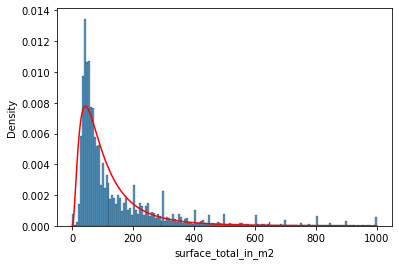

In [118]:
sns.histplot(surface_total_not_nulls, binrange =(0,1000),stat='density')
plt.plot(x,lognormal_fitted,'r-')

In [119]:
surface_total_lognorm_low = stats.lognorm.ppf(0.01, s_fit, loc=loc_fit, scale=scale_fit)
surface_total_lognorm_high = stats.lognorm.ppf(0.99, s_fit, loc=loc_fit, scale=scale_fit)

aux_low = surface_total_not_nulls < surface_total_lognorm_low
aux_high = surface_total_not_nulls > surface_total_lognorm_high
surface_total_outliers_porc = (aux_low.sum() + aux_high.sum()) / len(surface_total_not_nulls)

print('Umbral inferior: {:.4} m2'.format(surface_total_lognorm_low))
print('Umbral superior: {:.4} m2'.format(surface_total_lognorm_high))
print("Cantidad de datos que clasifico como outliers: {:.2}%".format(surface_total_outliers_porc * 100) )

Umbral inferior: 11.0 m2
Umbral superior: 570.7 m2
Cantidad de datos que clasifico como outliers: 7.2%


In [120]:
mask_high = df_price_surface_place_tidy['surface_total_in_m2'] < 570.7
mask_low = df_price_surface_place_tidy['surface_total_in_m2'] > 11.0
mask_not_outliers = np.logical_and(mask_high, mask_low)

df_surfaces_tidy = df_price_surface_place_tidy[mask_not_outliers].copy()

Una vez que se tiene un dataset con ambas columnas de superficie limpias, se realiza un primer análisis considerando solo las casas debido a que este es el tipo de propiedad donde se espera que la superficie total tenga mayor relevancia.

In [121]:
mask_house = df_surfaces_tidy['property_type'] == 'house'
df_house = df_surfaces_tidy[mask_house].copy()

Se considera una superficie media que se obtiene de hacer el promedio entre las dos columnas de superficie.

In [122]:
df_house['surface_mean'] = (df_house['surface_covered_in_m2'] + df_house['surface_total_in_m2']) / 2

In [123]:
df_house[['surface_total_in_m2', 'surface_covered_in_m2', 'price_aprox_usd', 'surface_mean']].corr()

,surface_total_in_m2,surface_covered_in_m2,price_aprox_usd,surface_mean
surface_total_in_m2,1.000000,0.612436,0.435802,0.920645
surface_covered_in_m2,0.612436,1.000000,0.736751,0.872456
price_aprox_usd,0.435802,0.736751,1.000000,0.633256
surface_mean,0.920645,0.872456,0.633256,1.000000


La correlacion entre la columna price_aprox_usd y las columnas de superficie arroja un mejor resultado para la superficie cubierta.
Se continua con el analisis agrupando por localidades

In [124]:
df_house_groupby = df_house.groupby('place')
ds_house_place_count = df_house_groupby['price_per_m2'].count()
ds_house_place_count.head()

place
Argentina|Bs.As. G.B.A. Zona Norte|Escobar                 744
Argentina|Bs.As. G.B.A. Zona Norte|General San Martín      306
Argentina|Bs.As. G.B.A. Zona Norte|José C Paz               42
Argentina|Bs.As. G.B.A. Zona Norte|Malvinas Argentinas     151
Argentina|Bs.As. G.B.A. Zona Norte|Pilar                  1136
Name: price_per_m2, dtype: int64

In [125]:
# Creo dataframe donde ir guardando los resultados obtenidos
df_house_place  = ds_house_place_count.to_frame(name='count')

In [126]:
# Se obtiene correlación entre price_aprox_usd y surface_covered
places = list(ds_house_place_count.index)
corrs_covered = []
corrs_total = []
corrs_mean = []
for place in places:
    mask_place = df_house['place'] == place
    price = df_house.loc[mask_place,'price_aprox_usd']
    surface_covered = df_house.loc[mask_place,'surface_covered_in_m2']
    correlacion_covered = np.corrcoef(price, surface_covered)[0,1]
    corrs_covered.append(correlacion_covered)
    
    surface_total = df_house.loc[mask_place,'surface_total_in_m2']
    correlacion_total = np.corrcoef(price, surface_total)[0,1]
    corrs_total.append(correlacion_total)
    
    surface_mean = df_house.loc[mask_place,'surface_mean']
    correlacion_mean = np.corrcoef(price, surface_mean)[0,1]
    corrs_mean.append(correlacion_mean)
    
ds_covered_place_corr = pd.Series(corrs_covered, index=places)
ds_total_place_corr = pd.Series(corrs_total, index=places)
ds_mean_place_corr = pd.Series(corrs_mean, index=places)
# se guardan valores en dataframe
df_house_place['price_covered_corr'] = ds_covered_place_corr
df_house_place['price_total_corr'] = ds_total_place_corr
df_house_place['price_mean_corr'] = ds_mean_place_corr


D:\anaconda3\envs\dhdsblend2021\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
D:\anaconda3\envs\dhdsblend2021\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
D:\anaconda3\envs\dhdsblend2021\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
D:\anaconda3\envs\dhdsblend2021\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
D:\anaconda3\envs\dhdsblend2021\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [127]:
df_house_place.head()

,count,price_covered_corr,price_total_corr,price_mean_corr
place,,,,
Argentina|Bs.As. G.B.A. Zona Norte|Escobar,744,0.720005,0.544955,0.681198
Argentina|Bs.As. G.B.A. Zona Norte|General San Martín,306,0.650960,0.418481,0.568590
Argentina|Bs.As. G.B.A. Zona Norte|José C Paz,42,0.579454,0.318926,0.494664
Argentina|Bs.As. G.B.A. Zona Norte|Malvinas Argentinas,151,0.865178,0.695175,0.825312
Argentina|Bs.As. G.B.A. Zona Norte|Pilar,1136,0.816688,0.659126,0.774796


Se muestran los resultados para las localidades con más propiedades

In [128]:
df_house_place.sort_values(by='count', ascending=False).head(10)

,count,price_covered_corr,price_total_corr,price_mean_corr
place,,,,
Argentina|Bs.As. G.B.A. Zona Norte|Tigre,2268,0.769483,0.541330,0.700964
Argentina|Bs.As. G.B.A. Zona Norte|Pilar,1136,0.816688,0.659126,0.774796
Argentina|Bs.As. G.B.A. Zona Norte|Escobar,744,0.720005,0.544955,0.681198
Argentina|Buenos Aires Costa Atlántica|Mar del Plata,736,0.728583,0.238876,0.554036
Argentina|Bs.As. G.B.A. Zona Norte|San Isidro,714,0.810690,0.652045,0.782788
Argentina|Bs.As. G.B.A. Zona Norte|Vicente López,629,0.844612,0.742141,0.823889
Argentina|Bs.As. G.B.A. Zona Oeste|La Matanza,513,0.787132,0.551492,0.711396
Argentina|Bs.As. G.B.A. Zona Oeste|Morón,503,0.749344,0.482572,0.659958
Argentina|Bs.As. G.B.A. Zona Sur|Lomas de Zamora,418,0.773681,0.606222,0.716426


Para todos los valores observados la superficie cubierta tuvo un mejor  desempeño.
En base a lo anterior, no se encuentran motivos fuertes para utilizar otra superficie que no sea surface_covered

<a id="section_final_clean"></a> 
## Limpieza final

[volver a TOC](#section_toc)

In [129]:
df_tidy = df_price_surface_place_tidy.copy()

One-hot encoding para columna property_type

In [130]:
# One hot encoding, binding y dropeo
def onehot_bind(data):
    dummies = pd.get_dummies(data['property_type'], prefix='proptype')
    df_binded = pd.concat([data, dummies], axis=1)
    return df_binded

# Creo un nuevo dataframe con la codificación

df_tidy = onehot_bind(df_tidy)

# Dropeo la columna extra

df_tidy.drop(['property_type'], axis=1, inplace=True)

Eliminación de columnas sin uso

In [131]:
df_tidy.dtypes

place_name                  object
place_with_parent_names     object
state_name                  object
lat-lon                     object
lat                        float64
lon                        float64
price_aprox_usd            float64
surface_total_in_m2        float64
surface_covered_in_m2      float64
price_usd_per_m2           float64
price_per_m2               float64
floor                      float64
rooms                      float64
expenses                   float64
description                 object
title                       object
place                       object
proptype_PH                  uint8
proptype_apartment           uint8
proptype_house               uint8
proptype_store               uint8
dtype: object

In [132]:
columns_to_drop= ['place_name', 'place_with_parent_names', 'state_name',
                 'lat-lon', 'lat', 'lon', 'surface_total_in_m2', 'price_usd_per_m2',
                 'price_per_m2', 'floor', 'rooms', 'expenses', 'description',
                 'title']

df_tidy.drop(columns_to_drop, axis=1, inplace=True)
df_tidy.reset_index(level=None, drop=True, inplace=True)

<a id="section_final_datasets"></a> 
## Datasets finales

[volver a TOC](#section_toc)

Dataset final

In [133]:
df_tidy.to_csv('Datasets finales\df_tidy.csv', index=False, encoding='utf-8')
df_tidy

,price_aprox_usd,surface_covered_in_m2,place,proptype_PH,proptype_apartment,proptype_house,proptype_store
0,62000.0,40.0,Argentina|Capital Federal|Mataderos,1,0,0,0
1,72000.0,55.0,Argentina|Capital Federal|Mataderos,0,1,0,0
2,64000.0,35.0,Argentina|Buenos Aires Costa Atlántica|Mar del...,0,1,0,0
3,130000.0,78.0,Argentina|Bs.As. G.B.A. Zona Norte|Vicente López,1,0,0,0
4,138000.0,40.0,Argentina|Capital Federal|Belgrano,0,1,0,0
...,...,...,...,...,...,...,...
82023,165000.0,39.0,Argentina|Capital Federal|Recoleta,0,1,0,0
82024,870000.0,93.0,Argentina|Capital Federal|Belgrano,0,1,0,0
82025,498000.0,360.0,Argentina|Bs.As. G.B.A. Zona Norte|San Isidro,0,0,1,0
82026,131500.0,39.0,Argentina|Capital Federal|Villa Urquiza,0,1,0,0


Dataseries que relaciona todas las localidades con su precio por metro cuadrado promedio.

NOTA: Contiene todas las propiedades

In [134]:
ds_place_price_per_m2.to_csv('Datasets finales\ds_place_price_per_m2.csv', index=False, encoding='utf-8')
ds_place_price_per_m2

place
Argentina|Bs.As. G.B.A. Zona Norte|Escobar                1403.893520
Argentina|Bs.As. G.B.A. Zona Norte|General San Martín     1415.662651
Argentina|Bs.As. G.B.A. Zona Norte|José C Paz              924.285714
Argentina|Bs.As. G.B.A. Zona Norte|Malvinas Argentinas    1360.000000
Argentina|Bs.As. G.B.A. Zona Norte|Pilar                  1551.724138
                                                             ...     
Argentina|Tierra Del Fuego|Río Grande                     1343.671354
Argentina|Tierra Del Fuego|Ushuaia                        2000.000000
Argentina|Tucumán|San Miguel de Tucumán                   1453.153134
Argentina|Tucumán|Tafí del Valle                           486.058467
Argentina|Tucumán|Yerba Buena                             1215.146292
Name: price_per_m2, Length: 421, dtype: float64

Dataset que relaciona las localidades con su precio por metro cuadrado para las localidades mejor correlacionadas 

NOTA: se consideraron correlaciones entre precio y superficie cubierta mayor a 0.75)

In [135]:
ds_place_price_per_m2_well_corr = ds_place_price_per_m2[places_well_corr].copy()
ds_place_price_per_m2_well_corr.to_csv('Datasets finales\ds_place_price_per_m2_well_corr.csv', index=False, encoding='utf-8')
ds_place_price_per_m2_well_corr

Argentina|Bs.As. G.B.A. Zona Norte|Malvinas Argentinas    1360.000000
Argentina|Bs.As. G.B.A. Zona Norte|Pilar                  1551.724138
Argentina|Bs.As. G.B.A. Zona Norte|San Fernando           2100.000000
Argentina|Bs.As. G.B.A. Zona Norte|San Isidro             2200.000000
Argentina|Bs.As. G.B.A. Zona Norte|San Miguel             1496.268657
                                                             ...     
Argentina|Santa Fe|Roldán                                 1089.007917
Argentina|Tierra Del Fuego|Río Grande                     1343.671354
Argentina|Tierra Del Fuego|Ushuaia                        2000.000000
Argentina|Tucumán|Tafí del Valle                           486.058467
Argentina|Tucumán|Yerba Buena                             1215.146292
Name: price_per_m2, Length: 176, dtype: float64

<a id="section_graphs"></a> 
## Gráficos con geopandas

[volver a TOC](#section_toc)

Se realizaron gráficos mostrando precios y precios por metro cuadrado para las distintas regiones del pais.
Esto se entrega en una notebook aparte por cuestiones de environments.

Notebook anexa geopandas: presentacion_geopandas